This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models that are structurally different. 

In [1]:
import ipywidgets as ipw
from IPython.display import display

from stochastic_models import model_lorentz, model_sir
from stochastic_tests import Test

t_fin = 10.0
num_steps = 200
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   trials=[100, 500, 1000, 5000, 10000], 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)])

test1 = Test(model=model_sir({'beta': ('norm', (2.0E-6, 0.2E-6))}), stochastic=False, **test_kwargs)
test1.model.results_names = ['S', 'I', 'R']
test2 = Test(model=model_lorentz(), stochastic=True, **test_kwargs)
tests = [test1, test2]

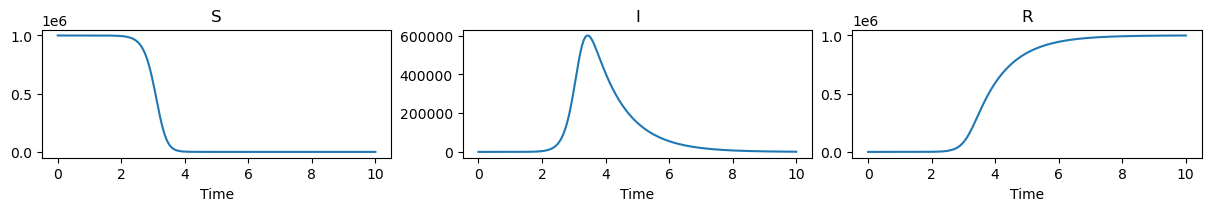

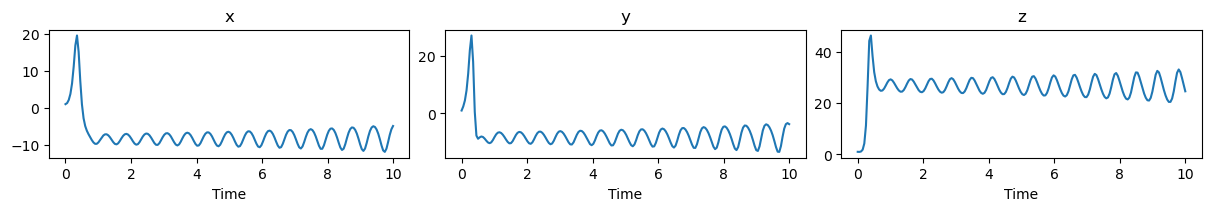

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

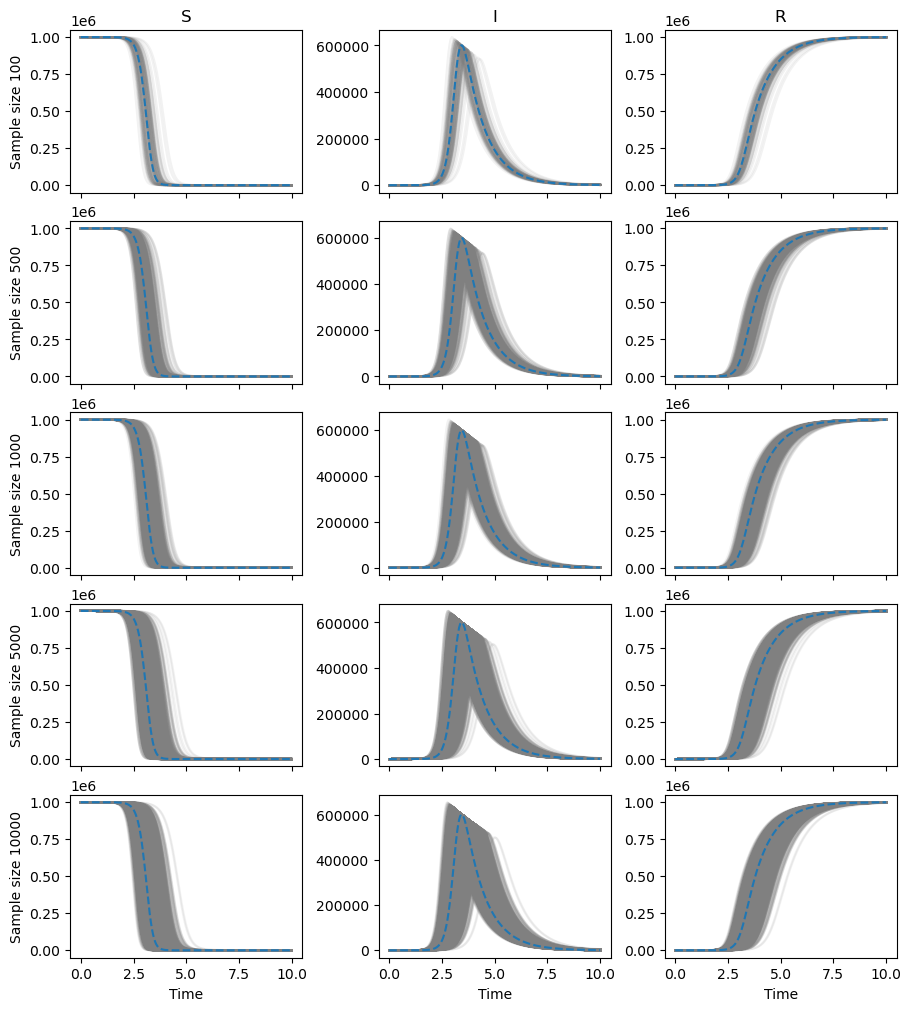

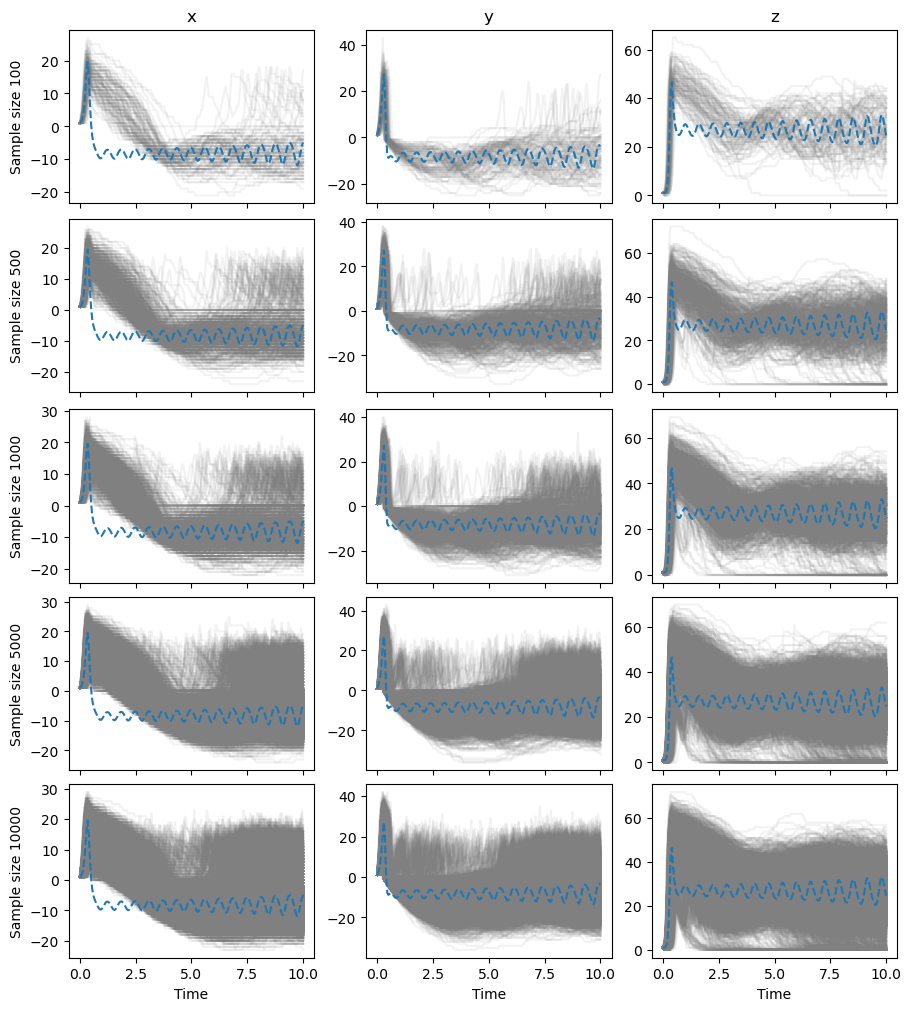

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

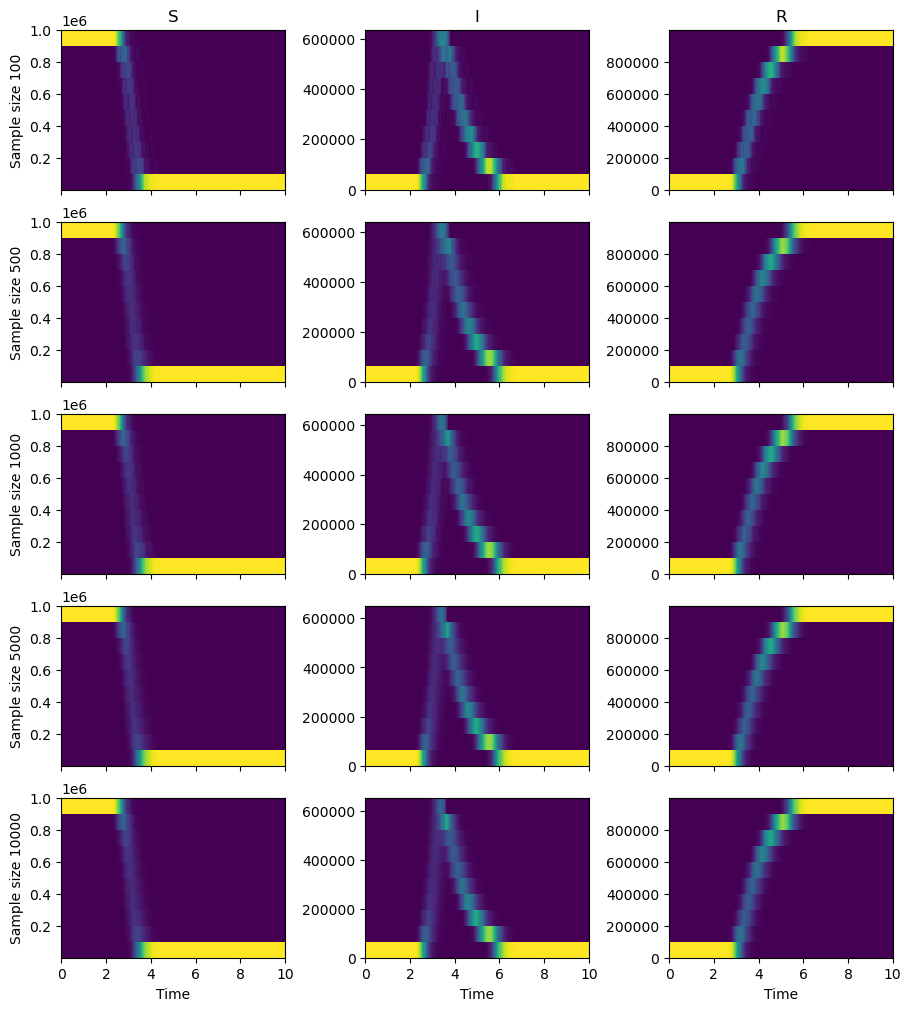

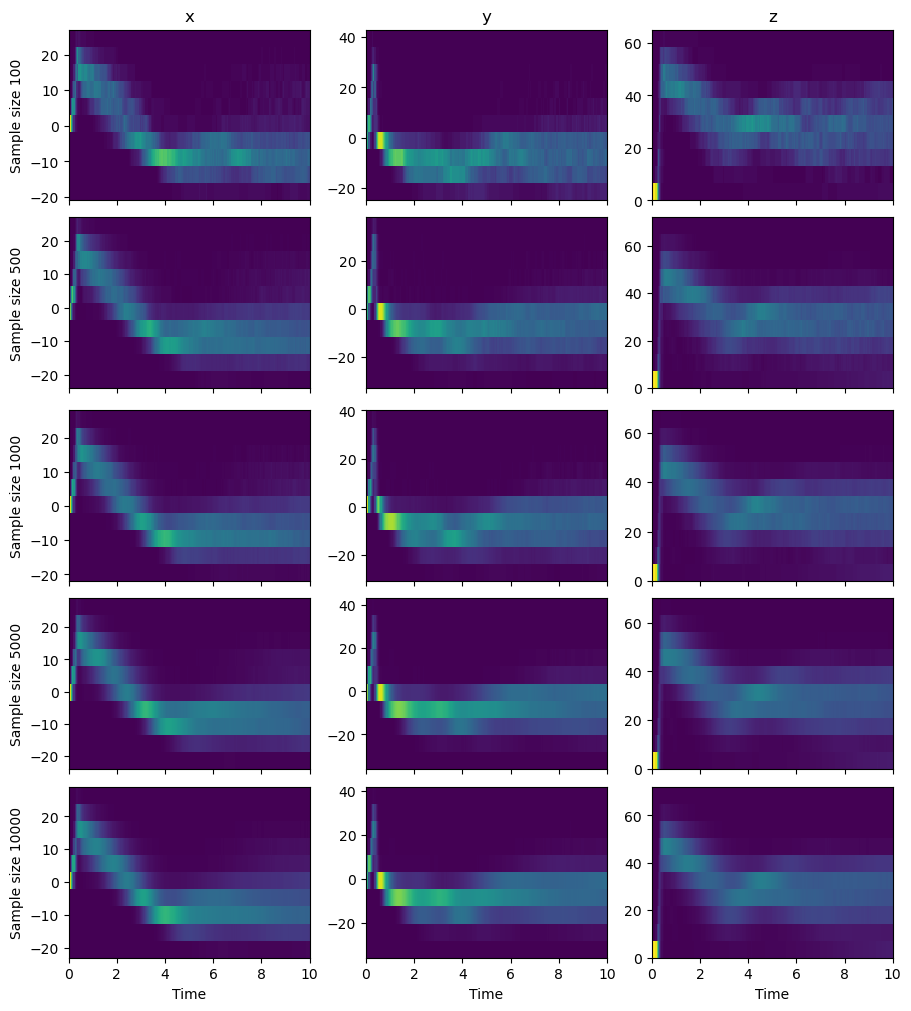

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


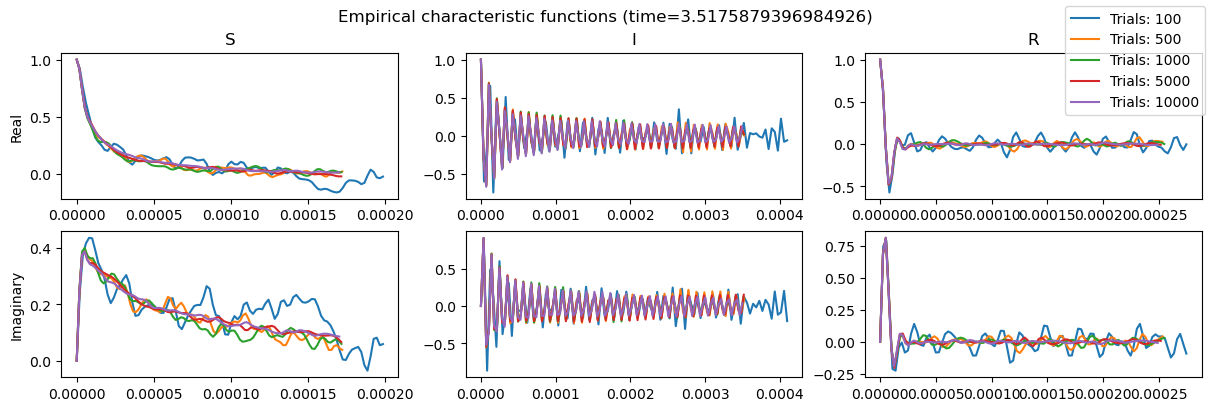

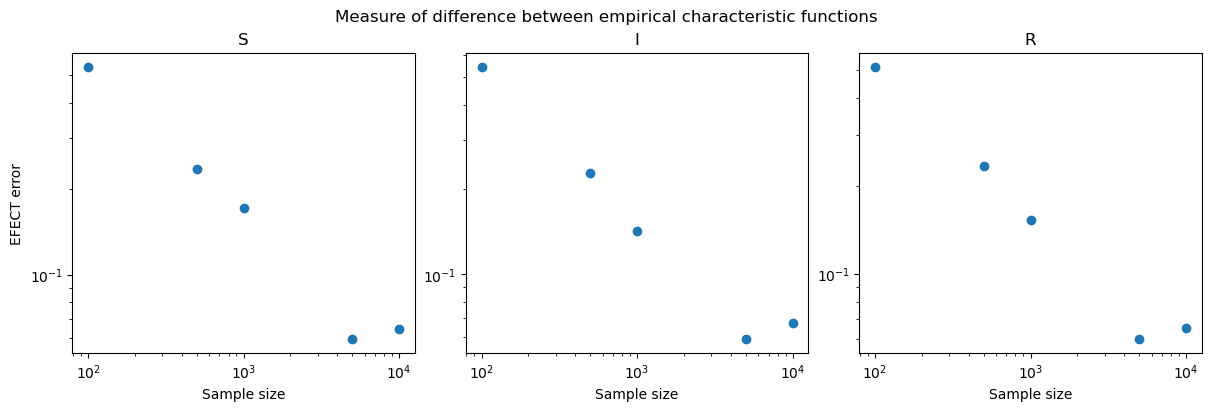

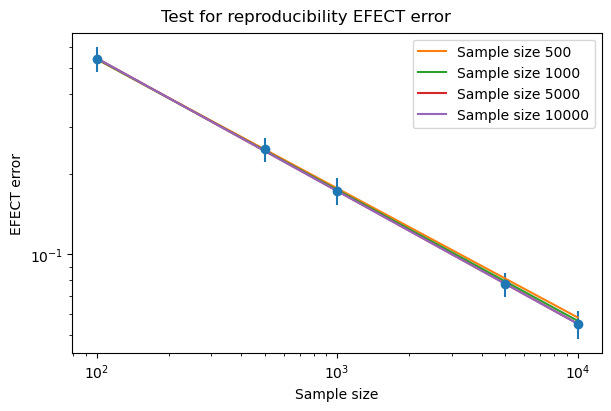

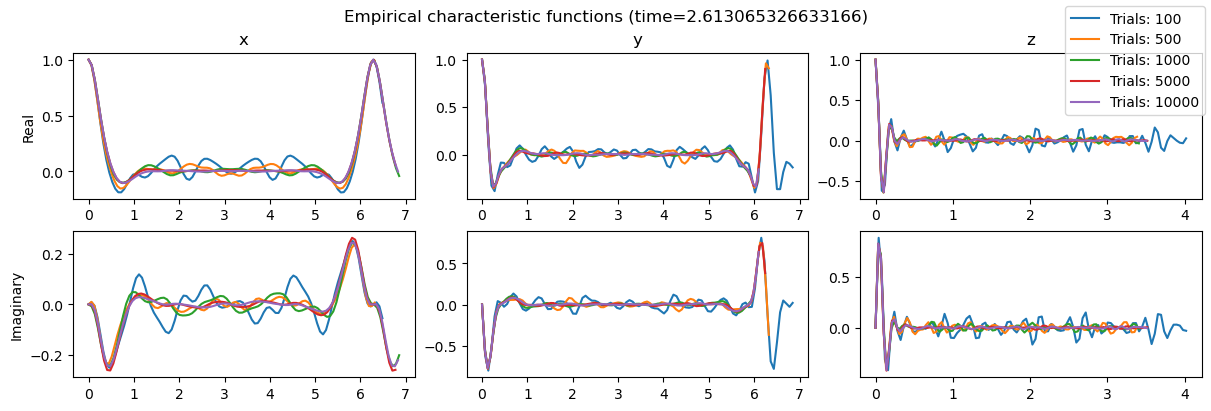

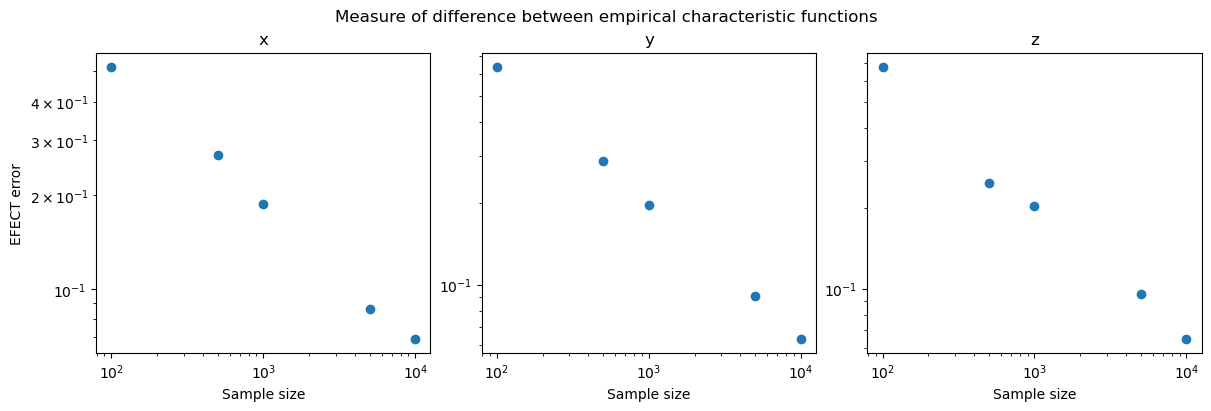

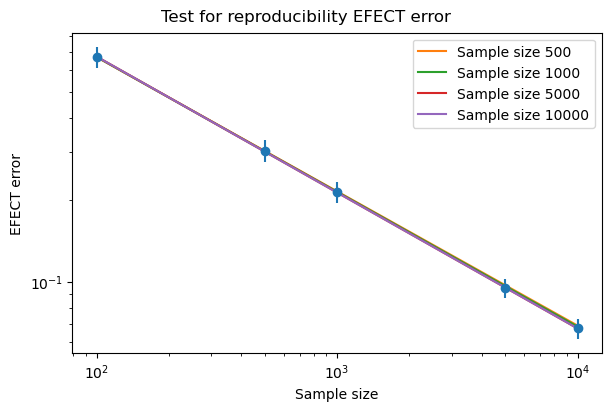

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(time=test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models are structurally different.

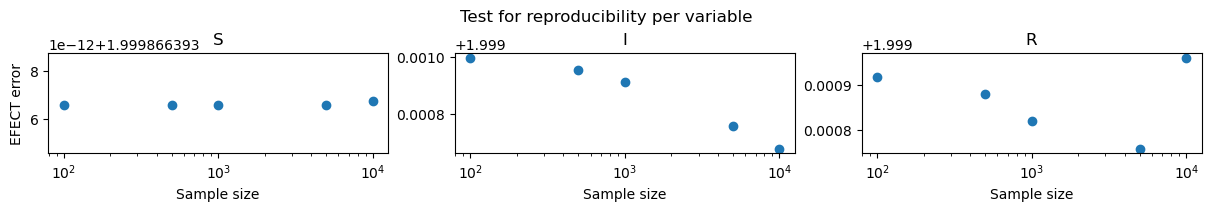

In [7]:
from matplotlib import pyplot as plt
import stochastic_repro as sr

# Trick the method into thinking that the models have the same variables

ecf_eval_info = {t: [] for t in test1.trials}
for t in test1.trials:
    for i in range(len(test1.sims_s[t].results_time)):
        ecf_eval_info[t].append({test2.model.results_names[i]: test1.ecf_eval_info[t][i][test1.model.results_names[i]] for i in range(len(test1.model.results_names))})
ecf2 = sr.generate_ecfs(test2.sims_s, test2.model.results_names, test1.trials, ecf_eval_info)
for t in test1.trials:
    for i in range(len(test1.sims_s[t].results_time)):
        for j in range(len(test1.model.results_names)):
            ecf2[t][i][test1.model.results_names[j]] = ecf2[t][i].pop(test2.model.results_names[j])

# Do the test

ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, ecf2)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')

for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([ei[name] for ei in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')